# TASK #1: IMPORTING LIBRARIES AND DATASET

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
# Mounting my drive using the following commands:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Specifying training data directory
XRay_Directory = '/content/drive/MyDrive/Colab Notebooks/Chest_X_Ray/4. Operations Department/train'

In [6]:
# Listing the folders in the directory
os.listdir(XRay_Directory)

['0', '3', '1', '2']

In [8]:
# Using image generator to generate tensor images data and normalize them
# Using 20% of the data for cross-validation
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2, rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [9]:
# Generating batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Performing shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="training")


Found 428 images belonging to 4 classes.


In [10]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")


Found 104 images belonging to 4 classes.


In [11]:
# Generating a batch of 40 images and labels
train_images, train_labels = next(train_generator)


In [12]:
train_images.shape

(40, 256, 256, 3)

In [13]:
train_labels.shape

(40, 4)

In [ ]:
train_labels

In [14]:
# labeling Translator
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

# TASK #2: VISUALIZE DATASET

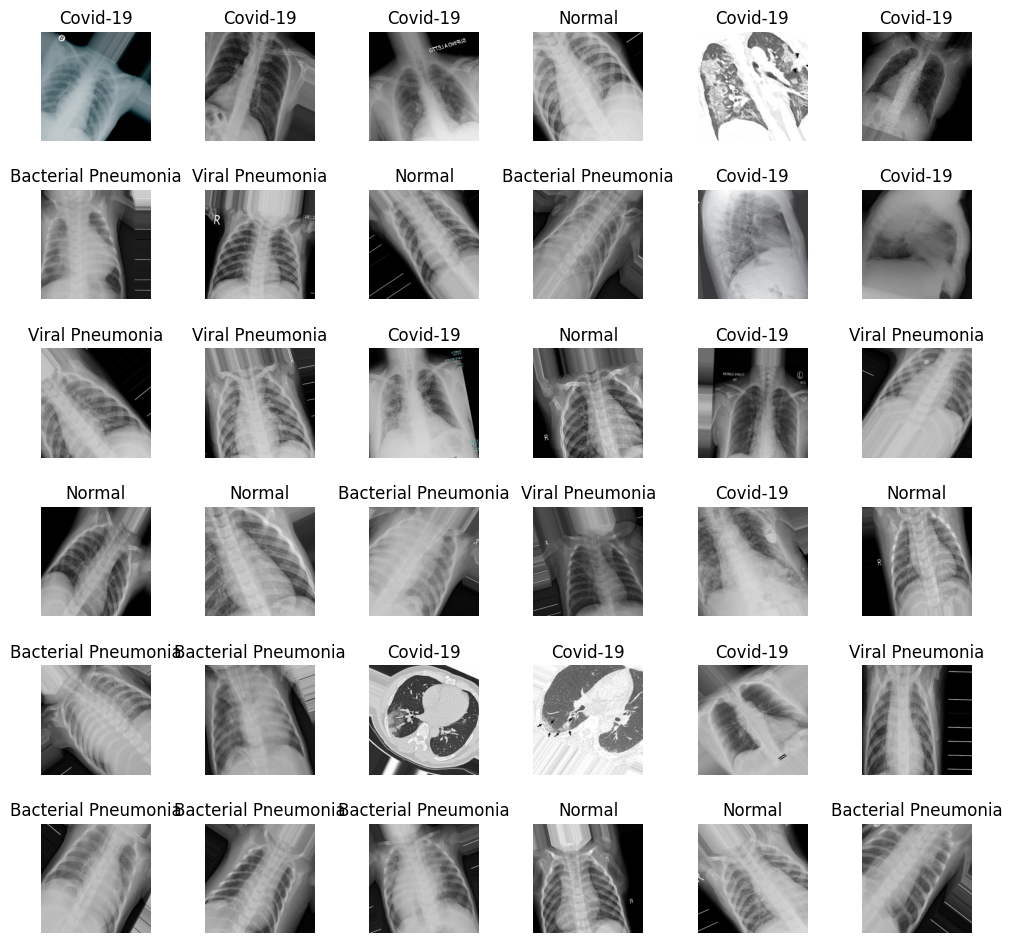

In [19]:
# Creating a grid of 36 images along with their corresponding labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

# TASK #3: IMPORT MODEL WITH PRETRAINED WEIGHTS

In [20]:
#Using RESNT50 Model for training the model.
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94765736/94765736 [==============================] - 1s 0us/step


In [21]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [38]:
#freezing the model upto the last stage

for layer in basemodel.layers:
  layers.trainable = False

# TASK #4: BUILD AND TRAIN DEEP LEARNING MODEL

In [39]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(1024, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(512, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [40]:
import keras

In [41]:
model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 1e-4), metrics= ["accuracy"])

In [42]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# saving the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [30]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [43]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 10, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

Epoch 1/10


<ipython-input-43-15bb0bd05a4a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 10, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])


107/107 [==============================] - ETA: 0s - loss: 1.0696 - accuracy: 0.5327
Epoch 1: val_loss improved from inf to 0.55058, saving model to weights.hdf5
107/107 [==============================] - 32s 243ms/step - loss: 1.0696 - accuracy: 0.5327 - val_loss: 0.5506 - val_accuracy: 0.8269
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 0.7180 - accuracy: 0.7407
Epoch 2: val_loss did not improve from 0.55058
107/107 [==============================] - 18s 172ms/step - loss: 0.7180 - accuracy: 0.7407 - val_loss: 0.6144 - val_accuracy: 0.7981
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.7547
Epoch 3: val_loss did not improve from 0.55058
107/107 [==============================] - 18s 170ms/step - loss: 0.6868 - accuracy: 0.7547 - val_loss: 0.8569 - val_accuracy: 0.6923
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 0.6169 - accuracy: 0.7944
Epoch 4: val_loss did not improve from 0.55058
107/107

# TASK #8: EVALUATE TRAINED DEEP LEARNING MODEL

In [44]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

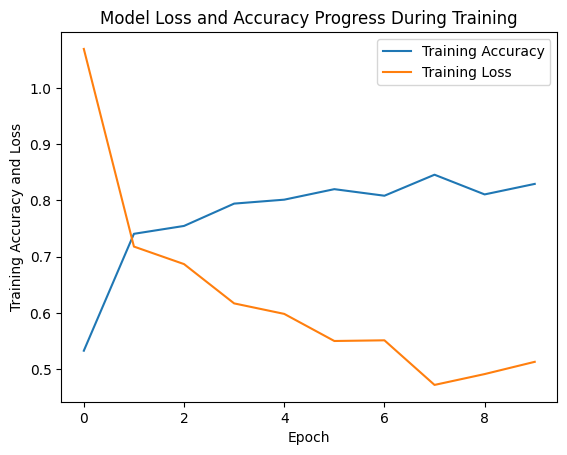

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

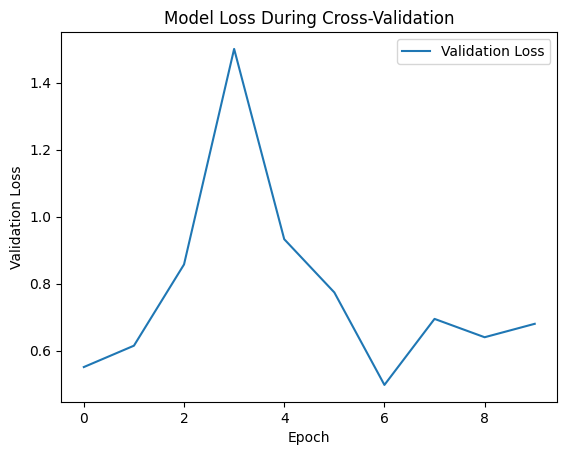

In [46]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

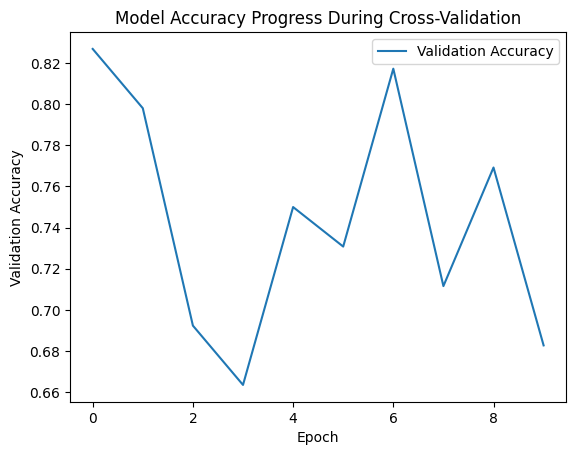

In [47]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [48]:
test_directory = '/content/drive/MyDrive/Colab Notebooks/Chest_X_Ray/4. Operations Department/Test'


In [49]:
test_gen = ImageDataGenerator(rescale = 1./255,  rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.


<ipython-input-49-133e5f5b4315>:11: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)


 1/10 [==>...........................] - ETA: 18s - loss: 0.7404 - accuracy: 0.8000

10/10 [==============================] - 2s 14ms/step - loss: 0.7404 - accuracy: 0.8000
Accuracy Test : 0.800000011920929


In [50]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 21ms/step


In [51]:
len(original)

40

In [52]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.85


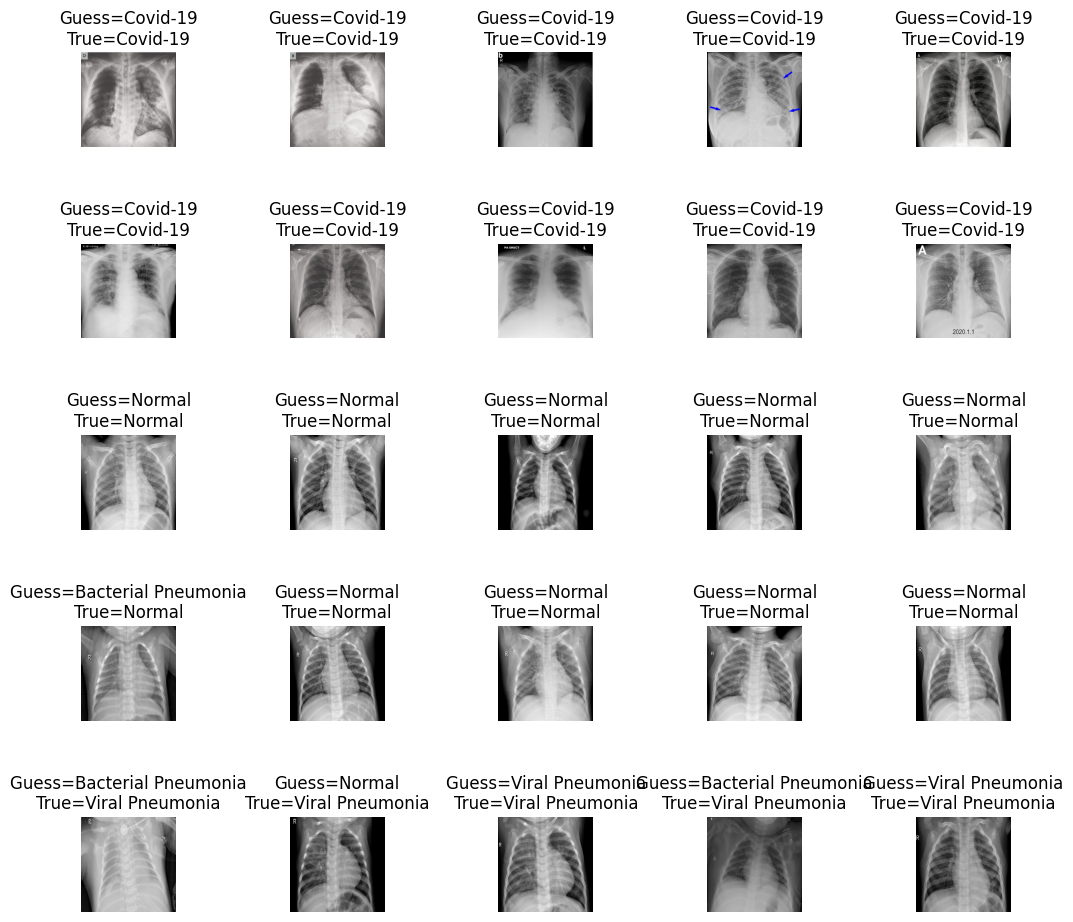

In [53]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2)

In [54]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.78      0.70      0.74        10
           3       0.73      0.80      0.76        10

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40



Text(0.5, 1.0, 'Confusion_matrix')

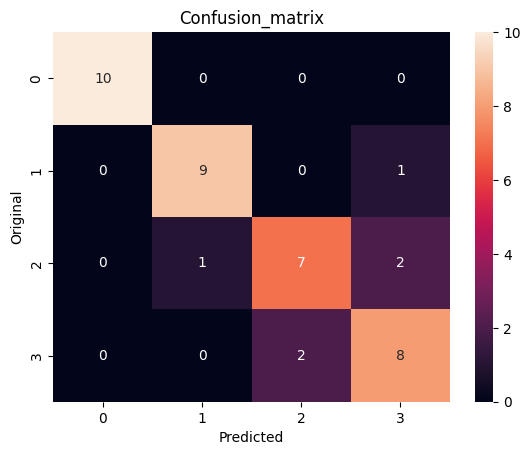

In [55]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')